In [1]:
import numpy as np
from astropy.table import Table, vstack
from astropy.io.fits import getdata
import scipy.stats as st
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor


import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

from bma_validation_class import bmaValidation

In [3]:
small_infile = 'small_table.fits'
small_table = Table(getdata(small_infile))
# Example of how to run
mass = small_table['mass']
mass_t= small_table['mass_t']
magi  = small_table['magi']
magi_true = small_table['magi_true']
z = small_table['z']
chisqr = small_table['chisqr']

mask = (z<=0.65)&(z>=0.2)&(magi<23.5)&(mass_t>9.)
variables = [mass,mass_t,magi,magi_true,z]

b1 = bmaValidation()
b1.add_model('baseline',*variables)

Welcome to BMA Validation


generating galpro model

In [4]:
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
point_estimates = np.load('point_estimates.npy')
mass_true = y_test[:,1]
mass = point_estimates[:]
mask_2 = (x_test[:,2]<23.5)&(y_test[:,0]<0.65)&(y_test[:,0]>0.2)&(mass_true>9.)

In [5]:
b2 = bmaValidation()
b2.add_model('galpro', mass, mass_true, mass, mass_true, y_test[:,0])

Welcome to BMA Validation


generating random forest model

In [8]:
def set_rf_params():
    """
    All hyperparameters for the random forest algorithm can be tuned here. Galpro uses the implementation of the
    algorithm in the Python machine learning library scikit-learn. For a detailed description of each hyperparameter
    please visit: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html.
    The most important hyperparameters are n_estimators, max_depth and max_features.
    """
    params = {
        'n_estimators': 100,
        'criterion': 'mse',
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'min_weight_fraction_leaf': 0,
        'max_features': 'auto',
        'max_leaf_nodes': None,
        'min_impurity_decrease': 0,
        'bootstrap': True,
        'oob_score': False,
        'n_jobs': -1,
        'random_state': None,
        'verbose': 0,
        'warm_start': False,
    }
    return params


def transform_to_1d(x, y):
    ynew = y[:, 1]
    xnew = np.vstack([x.T, y[:, 0]]).T
    return xnew, ynew[:, np.newaxis]
x_test1d, y_test1d = transform_to_1d(x_test, y_test)
x_train1d, y_train1d = transform_to_1d(x_train, y_train)


In [18]:
params = set_rf_params()

# Train model
print('Training model...')
model = RandomForestRegressor(**params)
model.fit(x_train1d, y_train1d)


Training model...


<ipython-input-18-6ee32c918341>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train1d, y_train1d)


RandomForestRegressor(min_impurity_decrease=0, min_weight_fraction_leaf=0,
                      n_jobs=-1)

In [19]:
#rf_mass = model.predict(x_test1d)
rf_mass = mass
rf_validation = bmaValidation()
rf_validation.add_model('random forest', rf_mass, y_test1d[:,0], rf_mass, y_test1d, y_test[:,0])

Welcome to BMA Validation


In [6]:
mask = (x_test[:,2]<23.5)&(y_test[:,0]<0.65)&(y_test[:,0]>0.2)&(mass_true>9.)

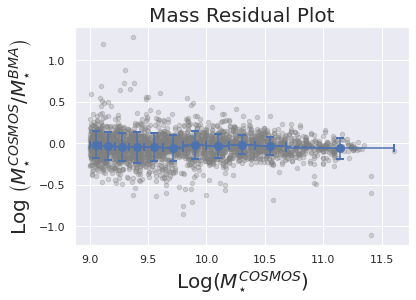

In [32]:
rf_validation.plot_residual_mass('rf', mask=mask)

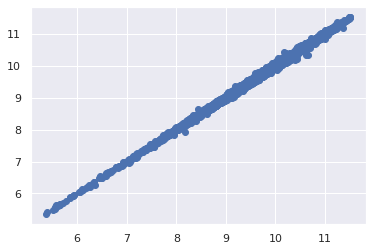

In [33]:
plt.scatter(rf_mass,mass)

#h2 artificial neural net

In [9]:
neural_net_model = MLPRegressor()
neural_net_model.fit(x_train1d, y_train1d)

/data0/sw/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MLPRegressor()

In [11]:
nn_mass = neural_net_model.predict(x_test1d)

nn_validation = bmaValidation()
nn_validation.add_model('random forest', nn_mass, y_test1d[:,0], nn_mass, y_test1d, y_test[:,0])

Welcome to BMA Validation


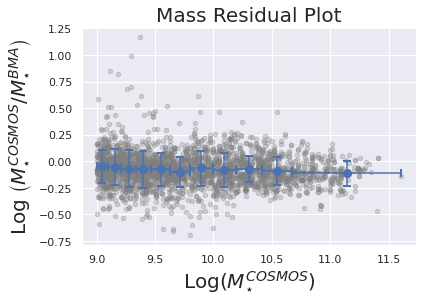

In [16]:

nn_validation.plot_residual_mass('neural net 1', mask=mask)

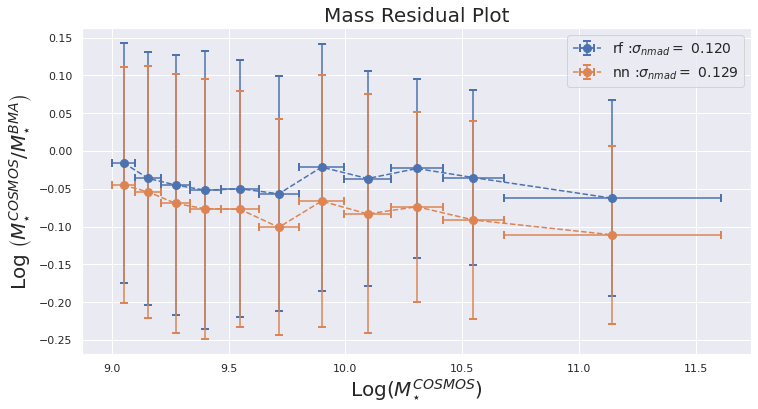

In [20]:
fig, axis = plt.subplots(1, 1, figsize=(12,6))

rf_validation.plot_residual_mass('rf', ax = axis, scatter=0, mask = mask_2)
nn_validation.plot_residual_mass('nn', ax = axis, scatter=0, mask = mask)
axis.legend(fontsize = 14)

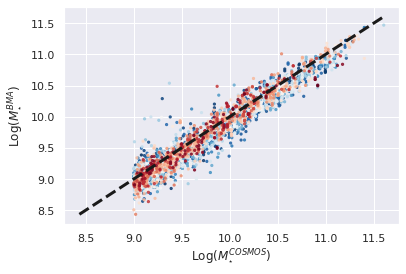

In [17]:
nn_validation.plot_identity_mass_redshift(mask=mask)

In [23]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.1,s=5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline

lasso_pipeline = make_pipeline(LassoCV())

rf_pipeline = make_pipeline(RandomForestRegressor(random_state=42))

params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
gradient_pipeline = make_pipeline(GradientBoostingRegressor())

kwargs = {'hidden_layer_sizes':(14, ), 'activation':'relu','random_state':1, 'max_iter':10000, 'solver':'lbfgs'}                  
ann_pipeline = make_pipeline(MLPRegressor(**kwargs))


estimators = [('Random Forest', rf_pipeline),
              ('Lasso', lasso_pipeline),
              ('Gradient Boosting', gradient_pipeline),
              ('ANN', ann_pipeline)]

In [26]:
x = x_train1d
y = y_train1d

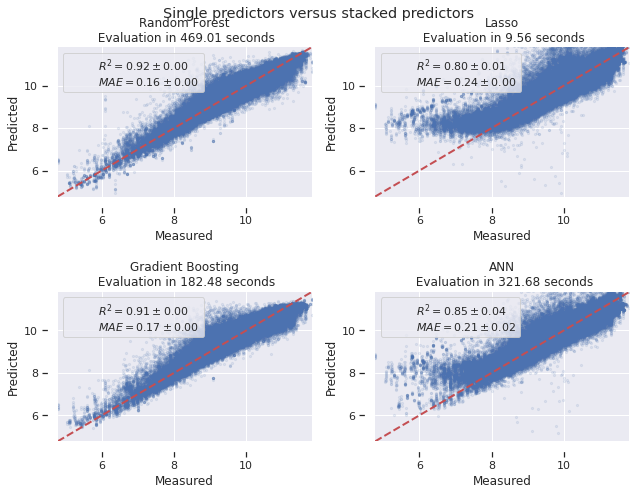

In [27]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators):
    start_time = time.time()
    score = cross_validate(est, x, y,
                           scoring=['r2', 'neg_mean_absolute_error'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, x, y, n_jobs=-1, verbose=0)

    plot_regression_results(
        ax, y, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_absolute_error']),
                np.std(score['test_neg_mean_absolute_error'])),
        elapsed_time)

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
